# Mapping barcodes and promoters

© 2022 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In [1]:
using wgregseq, CSV, DataFrames, Glob, BioSequences, CairoMakie, Statistics

wgregseq.plotting_style.default_makie!()

## Import Data for 110

In [2]:
# Import data file
df_110 = CSV.read(
    "../../../data/barcodes/20220514_mapping/110_collapsed.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_110.barcode = map(x -> LongDNA{4}(x), df_110.barcode)
df_110.promoter = map(x -> LongDNA{4}(x), df_110.promoter)

# Display first lines
first(df_110, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,12585,TTATTAGGATCCCTCACCAA,CGGGGATGTTTTGGCGCGTTACTTGCGCTTCTAGTTTGGTTTTTCGTGCCGTATGTTCGTGCGGTTACAGGCGTTAGATTCACCTACTTTTGTGAATGTATGTAGCATAGCTCAACGACAATATAAACGCAGTAATGGGTTTATTAACTTTTGACCATTG
2,11223,GTCCCGATGGGCACCGATAA,TTTGACTGCCGATTGAGAAGTCATGTGTTAAATGGCGGCACATACATGCACTATGGCACATAACGCCAACCTCTTGCCGTAGCGGCTTCTGCTAGTATCCGCAATAATTTTACATTGTAATCGCGCTAAATACTGCTTCACCACAAGGAATTCAAATGAA
3,8181,GGCGGACTCTTTGACTTTCG,GCCTGCATGTCAAAGTCCTGGTAAAAGTCTTATTGTGACGGAAAACGAACGCCACGCAAAGCTAACCGGACAATAGTGTAGTGCTTTTCTGTGCTTAGCGGTTAGAATATTCTCATCACTATATCTGGCGTTGTCCATGTTATAGTTATTAAAAAGTTTA
4,7576,CAATGCTGTCGAACACATTC,CAGCCCATAGAGGAACTGCAACTATTGCAAATGAAGAAATTAAGCTGGATGGCATCGCGCAATGAGGAAGATTGGCCGGGGCTGACAGTAAATAGCAATCGTAGAATCAGCCGCAAGCCCGAAAGATTCCAGTGAGGCGCAATGTTCCGGGGGCTTTAGC
5,6880,ATTCGGTATTTAATATCGCC,TGGATCTGACTGGAGTGAGATAGGCATCATCTAACGCATCGTCGCTAATACCATACTAAAACGATTGTAACGACGTGCTGCTTTCATAACCTGCACGTACTGTATGATTATCCAGTTAGCTCTGAGGCGTTTTCACGCTGGCAAGGCGCATAAACTCTTT


## Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [3]:
df_filt_110 = df_110[df_110.counts .> 2, :]
last(df_filt_110, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAAGTTTTGCTTTGTT,GCACTATGAATGGGCAGTGAGTGCGTTTTTTTGTCCCAAGTCGTCGTCTTTACTGAGCAAAAAAAATAATATCTCCTATACGAGAATCAACACTTGGGGTGAATAAGTTTTGCGTCGCCAGAGCGTTTTATATTGATAGGAGTCAAATTATGGAAGGTAA
2,3,AAAAAAAGTGTATATCTTTT,CTGGCTTAAGCATTGTTATTGACCTGGCACTAATAGTGAATTAAATGTGAACTTCAGCGTCGTTTGACTGCCGTTTGAGCAGTCATGCGTTATATTGAGGCTCATTACCCCCCAATGACACGTAACGCCAACCTTTTTCCGTAGCCGCTCTTGCTATAAC
3,3,AAAAAAAGACCTTTGTAGGA,TGGCTCTGGCTGGAGTGAGATACCCATCGTCTATGGCAGAAATGCTAACACCATACTGAAATTATTGCAAGGACGTGCTGGTATTATAACCTGCATGTACTGTATCATTATCCAGTTAGCTCTAAGCCATTTCCTCTCTGGCAATGCGCAGAAACGCTTT
4,3,AAAAAAACTAGGCCGGTTTT,GCACAAAGAATGCGCAGAGAGCGCTTTTTTTTGTCCCCAGTCATCCCCTTTACTGAGCAAAGCAAAGAATGTCTCCTACATGAGTAGGATCAATCGGAGATAATAAGTTTTGCTTCCCCAGAGCGTTTAATATTGATAGGAGGCTTATTCTGGAAGGTAA
5,3,AAAAAAAATGACAAATGAAG,CGAAGATGTGTTGGCGGGTTTCTGGCGCTTCTTGTTTGGTTTATCGTGCCATATGTGCGTGAATTTACAGTCGTTAGAGTGACATACATTGGTGAATGTAAGTACCATAGCACGACGATAATATAAACGAAGCAATGGGTTTGTTAAAATTTGACCATAT


## Identify promoters

Now we import the twist order to identify the sequences for each type.

In [4]:
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")

promoter_seqs = [seq[27:196] for seq in df_seqs.sequence]
insertcols!(df_seqs, 2, :promoter_seq => [x[27:186] for x in df_seqs.sequence])

first(df_seqs, 5)

,genes,promoter_seq
,Array…,LongSequ…
1,"[""rspA"", ""rspB""]",TTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAACATGAAGATCGTAAAGG
2,"[""rspA"", ""rspB""]",TCTGATCTTTTGTAAATCATTCACAGTGCAAATTTAAGTCTTTTTTTGTGATCACTCCGGCTATATTCGATCTATTTACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCGTCACGACAAGCGACGCAGGGAATCGAATATGAAGATCGTAAAGG
3,"[""rspA"", ""rspB""]",TTTCATCTTTTCTCAACCACTCACAGCGTAAACTTACGCCTGTTTGTGTGATCACTACGGCGTTTTTCAATCTTTATACTTGTATGGTAGTCTCTCAGTTGCGTAGATTTGCTGCATCACGACAAGCGATGCATGGAATCGAACATGAAGGTCGTAAAGG
4,"[""rspA"", ""rspB""]",GTTCATCCTTCTTCAACCATTCACAGCGGAAATATACGCCTTTTCTCGAGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTGAGTTGTGTAGTTTTCATGCATCACAACACGCGATGCAAGGAATGAAACATGAGGATCGTAAAGG
5,"[""rspA"", ""rspB""]",TTTCATCTTTTGTCAACCATTCACCGCGCAAATATACGCCTTCTTTTGTGATCACTCAGGCTCTTTTCGATCTTTCTACTAGTATGGTAATAGCTAATTTGCGTGGATTGCATGCATCACGACAAGCATTGCAAGGAATCGAACACGAAGATCCTTAAGG


In [5]:
# Store twist sequences in dictionary
dict_twist_sequences = Dict(df_seqs.promoter_seq .=> df_seqs.promoter);
dict_twist_primer2 = Dict(df_seqs.promoter_seq .=> df_seqs.rev_primer2);
dict_twist_primer3 = Dict(df_seqs.promoter_seq .=> df_seqs.rev_primer3);

In [6]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_110)
    try
        push!(name_list, dict_twist_sequences[df_filt_110.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_110.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_110.promoter[i]])
    catch e
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_110, 1, :name => name_list);
insertcols!(df_filt_110, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_110, 3, :rev_primer3 => primer3_list);

┌ Warning: Could not find font /Users/tomroschinger/.julia/packages/Makie/lgPZh/assets/fonts/NotoSans-Regular.tff, using Dejavu Sans
└ @ Makie /Users/tomroschinger/.julia/packages/Makie/lgPZh/src/conversions.jl:946


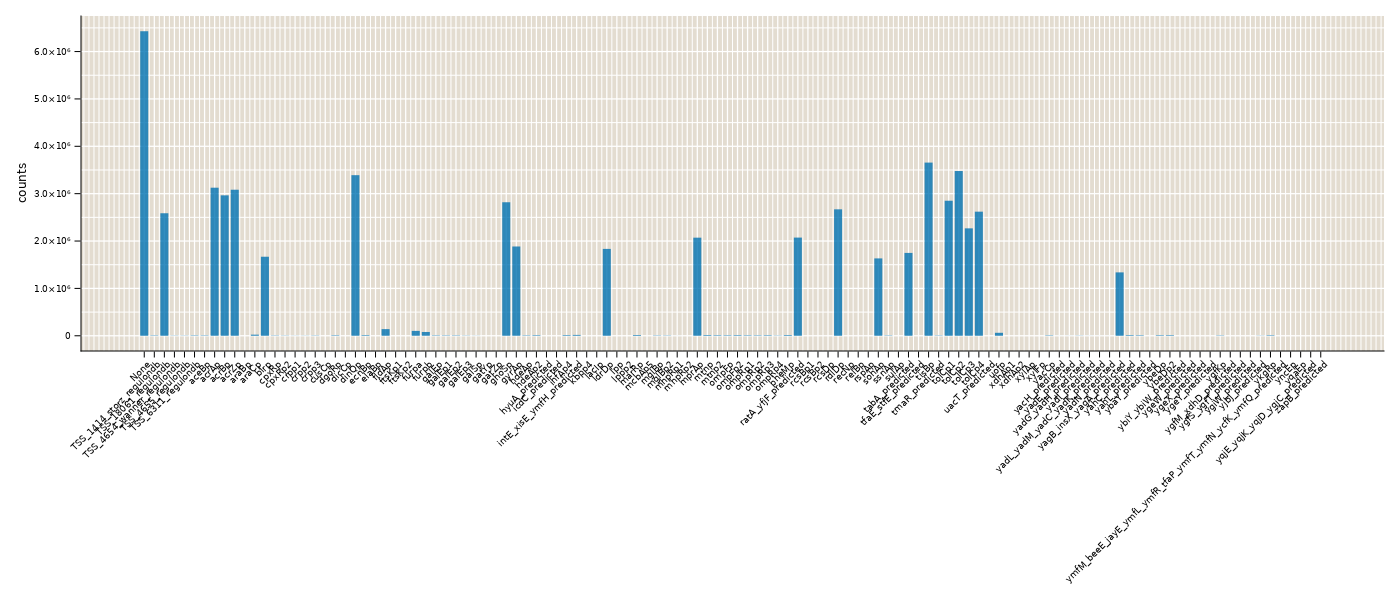

In [7]:
df_per_promoter_110 = combine(groupby(df_filt_110, :name), :counts => sum => :counts)
sort!(df_per_promoter_110, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts,
)

ax.xticks = (1:nrow(df_per_promoter_110), df_per_promoter_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

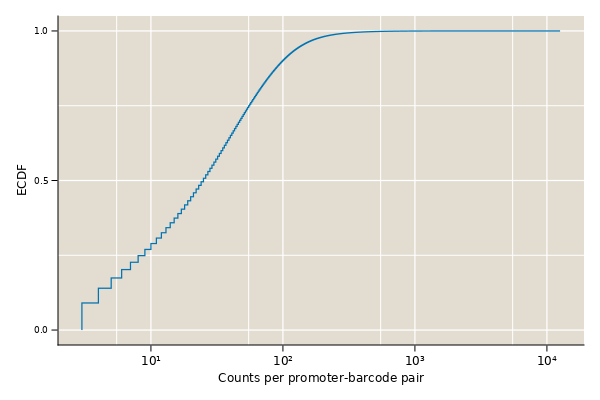

In [8]:
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
ax.ylabel = "ECDF"
ax.xlabel = "Counts per promoter-barcode pair"
ax.xticklabelsize=12
lines!(ax, sort(df_filt_110.counts),1/nrow(df_filt_110):1/nrow(df_filt_110):1)
fig

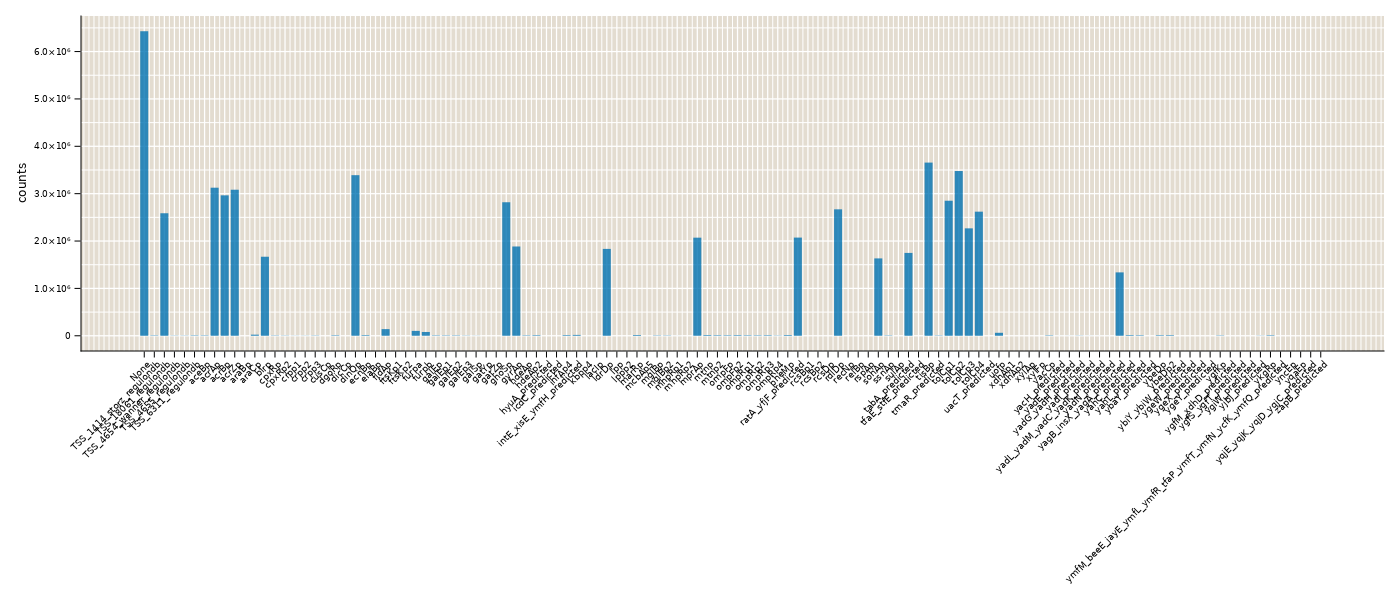

In [9]:
df_mean_barcodes_110 = combine(groupby(combine(groupby(df_filt_110, [:promoter, :name]), nrow), :name), :nrow => mean => :mean_barcodes)
sort!(df_mean_barcodes_110, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts,
)

ax.xticks = (1:nrow(df_per_promoter_110), df_per_promoter_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

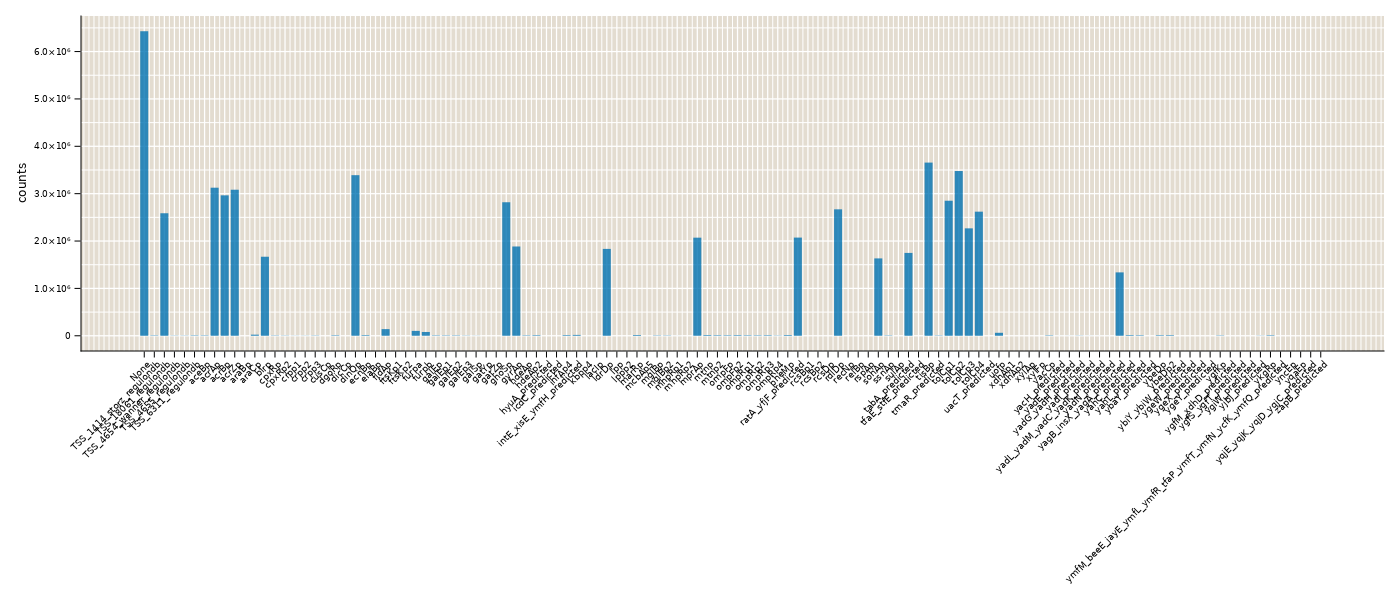

In [10]:
df_per_promoter_110 = combine(groupby(df_filt_110, :name), :counts => sum => :counts)
sort!(df_per_promoter_110, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_110), 
    df_per_promoter_110.counts,
)

ax.xticks = (1:nrow(df_per_promoter_110), df_per_promoter_110.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

In [11]:
df_per_p3 = combine(groupby(df_filt_110, :rev_primer3), :counts => sum => :counts)

,rev_primer3,counts
,Tuple…,Int64
1,"(201, (212, 230))",49764000
2,"(0, (0, 0))",6429138
3,"(203, (212, 230))",54197
4,"(205, (212, 230))",413041
5,"(204, (212, 230))",85960
6,"(202, (212, 230))",58760
7,"(207, (212, 230))",35498
8,"(208, (212, 230))",128540
9,"(206, (212, 230))",24951


## Import Data for 201

In [12]:
# Import data file
df_201 = CSV.read(
    "../../../data/barcodes/20220514_mapping/201_collapsed.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_201.barcode = map(x -> LongDNA{4}(x), df_201.barcode)
df_201.promoter = map(x -> LongDNA{4}(x), df_201.promoter)

# Display first lines
first(df_201, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,13287,TTATTAGGATCCCTCACCAA,CGGGGATGTTTTGGCGCGTTACTTGCGCTTCTAGTTTGGTTTTTCGTGCCGTATGTTCGTGCGGTTACAGGCGTTAGATTCACCTACTTTTGTGAATGTATGTAGCATAGCTCAACGACAATATAAACGCAGTAATGGGTTTATTAACTTTTGACCATTG
2,11802,GTCCCGATGGGCACCGATAA,TTTGACTGCCGATTGAGAAGTCATGTGTTAAATGGCGGCACATACATGCACTATGGCACATAACGCCAACCTCTTGCCGTAGCGGCTTCTGCTAGTATCCGCAATAATTTTACATTGTAATCGCGCTAAATACTGCTTCACCACAAGGAATTCAAATGAA
3,8333,GGCGGACTCTTTGACTTTCG,GCCTGCATGTCAAAGTCCTGGTAAAAGTCTTATTGTGACGGAAAACGAACGCCACGCAAAGCTAACCGGACAATAGTGTAGTGCTTTTCTGTGCTTAGCGGTTAGAATATTCTCATCACTATATCTGGCGTTGTCCATGTTATAGTTATTAAAAAGTTTA
4,7848,CAATGCTGTCGAACACATTC,CAGCCCATAGAGGAACTGCAACTATTGCAAATGAAGAAATTAAGCTGGATGGCATCGCGCAATGAGGAAGATTGGCCGGGGCTGACAGTAAATAGCAATCGTAGAATCAGCCGCAAGCCCGAAAGATTCCAGTGAGGCGCAATGTTCCGGGGGCTTTAGC
5,7379,ATTCGGTATTTAATATCGCC,TGGATCTGACTGGAGTGAGATAGGCATCATCTAACGCATCGTCGCTAATACCATACTAAAACGATTGTAACGACGTGCTGCTTTCATAACCTGCACGTACTGTATGATTATCCAGTTAGCTCTGAGGCGTTTTCACGCTGGCAAGGCGCATAAACTCTTT


## Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [13]:
df_filt_201 = df_201[df_201.counts .> 2, :]
last(df_filt_201, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAATGTACGTCAACAG,CTAGCTTAAGCATCGTTAATGTCCTGGCTCTGATAGTGAATTAAATGTGAATATCAGCGACGTTTGACTGACGTATAAGCAGGCATGTGTTAAAATGAGGCACATTAACGCCCTATGGCTCGTACCGCCAACCTTTGGCGGTATCGACTTCAGCTAGAAT
2,3,AAAAAAAGTTTTGCTTTGTT,GCACTATGAATGGGCAGTGAGTGCGTTTTTTTGTCCCAAGTCGTCGTCTTTACTGAGCAAAAAAAATAATATCTCCTATACGAGAATCAACACTTGGGGTGAATAAGTTTTGCGTCGCCAGAGCGTTTTATATTGATAGGAGTCAAATTATGGAAGGTAA
3,3,AAAAAAAGTGTATATCTTTT,CTGGCTTAAGCATTGTTATTGACCTGGCACTAATAGTGAATTAAATGTGAACTTCAGCGTCGTTTGACTGCCGTTTGAGCAGTCATGCGTTATATTTAGGCTCATTACCCCCCAATGACACGTAACGCCAACCTTTTGCCGTAGCCGCTCTTGCTATAAC
4,3,AAAAAAAGTGCCCATTGCGC,TGTGTCTTACCTTCGGCGACGGCGCTTTTCACATTGCCCCAGGCATTATTCCAGTACAGGGAAAGCGCTACTACCGTATAGCCTTCTCGATTGACGCGACCGTACAATGAGTCCAGTTCGCGCCGGTGGAGAATTAACTTGCGGGTACATGTAGGCTCGC
5,3,AAAAAAAATGGTGGTAACTT,CGATGATGTGTTGGCGGGTATCTTGAACGTCTGGTTTGATTTTTCGTGCCATATGTTCGTTAATTTACAGGCTTTAGATTAACAAACAGTTGTGAATGTATGTACCGTACCACGACGATAATATAAACGCACCAATGGGTTTATTAACTTTTGACCATTG


## Identify promoters

In [14]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_201)
    try
        push!(name_list, dict_twist_sequences[df_filt_201.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_201.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_201.promoter[i]])
    catch e
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_201, 1, :name => name_list);
insertcols!(df_filt_201, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_201, 3, :rev_primer3 => primer3_list);

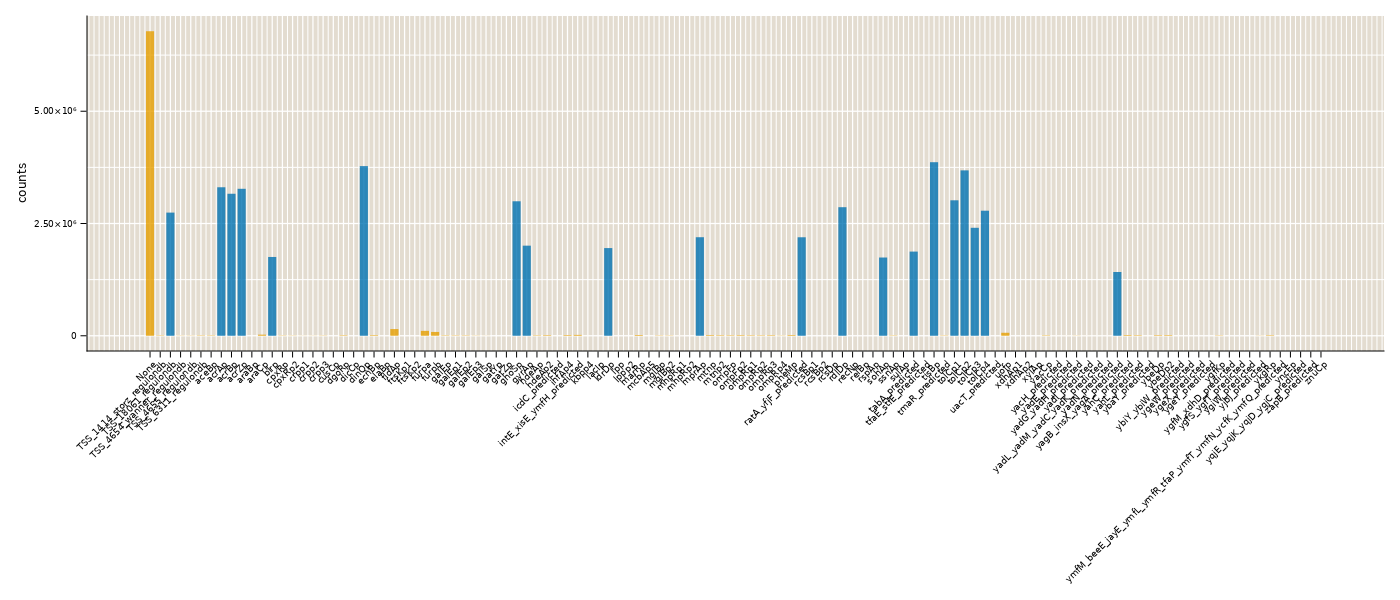

In [46]:
df_per_promoter_201 = combine(groupby(df_filt_201, [:name, :rev_primer3]), :counts => sum => :counts)
sort!(df_per_promoter_201, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])

barplot!(
    ax, 
    1:nrow(df_per_promoter_201), 
    df_per_promoter_201.counts .* map(x -> x[1] == 201, df_per_promoter_201.rev_primer3)
)

barplot!(
    ax, 
    1:nrow(df_per_promoter_201), 
    df_per_promoter_201.counts .* map(x -> x[1] != 201, df_per_promoter_201.rev_primer3)
)

ax.xticks = (1:nrow(df_per_promoter_201), df_per_promoter_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

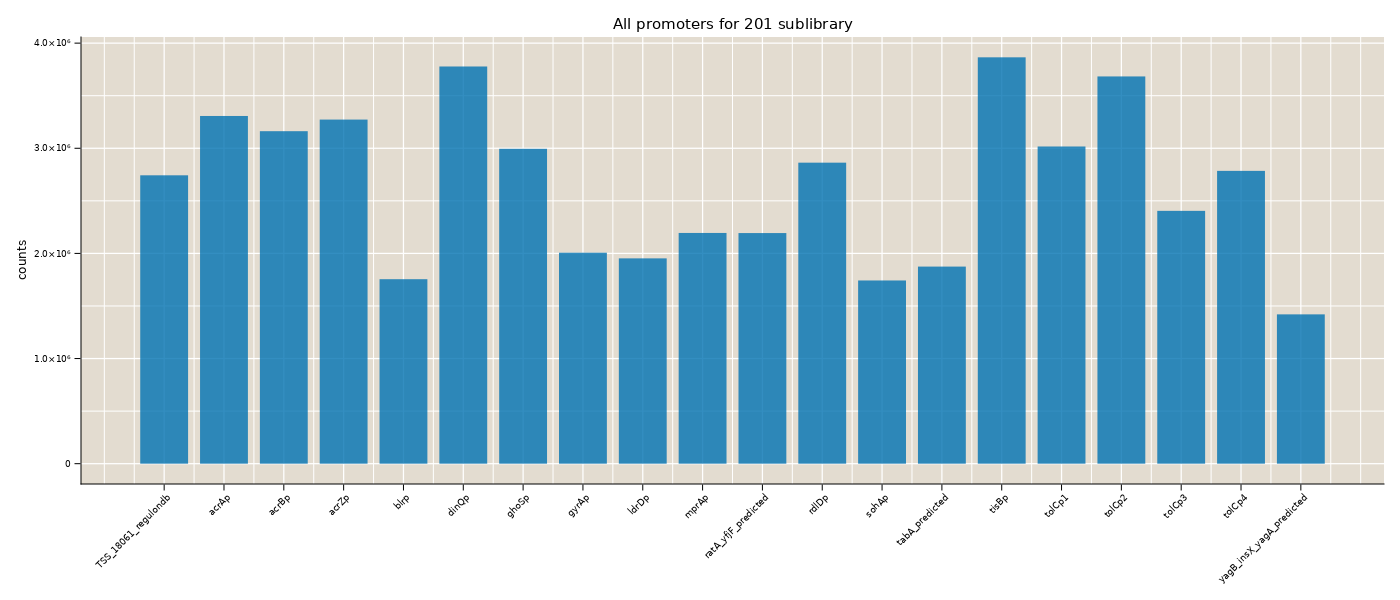

In [16]:
df_per_promoter_201_only = df_per_promoter_201[map(x -> x[1] == 201, df_per_promoter_201.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_201_only), 
    df_per_promoter_201_only.counts,
)

ax.xticks = (1:nrow(df_per_promoter_201_only), df_per_promoter_201_only.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"
ax.title = "All promoters for 201 sublibrary"
ax.titlesize=15

fig

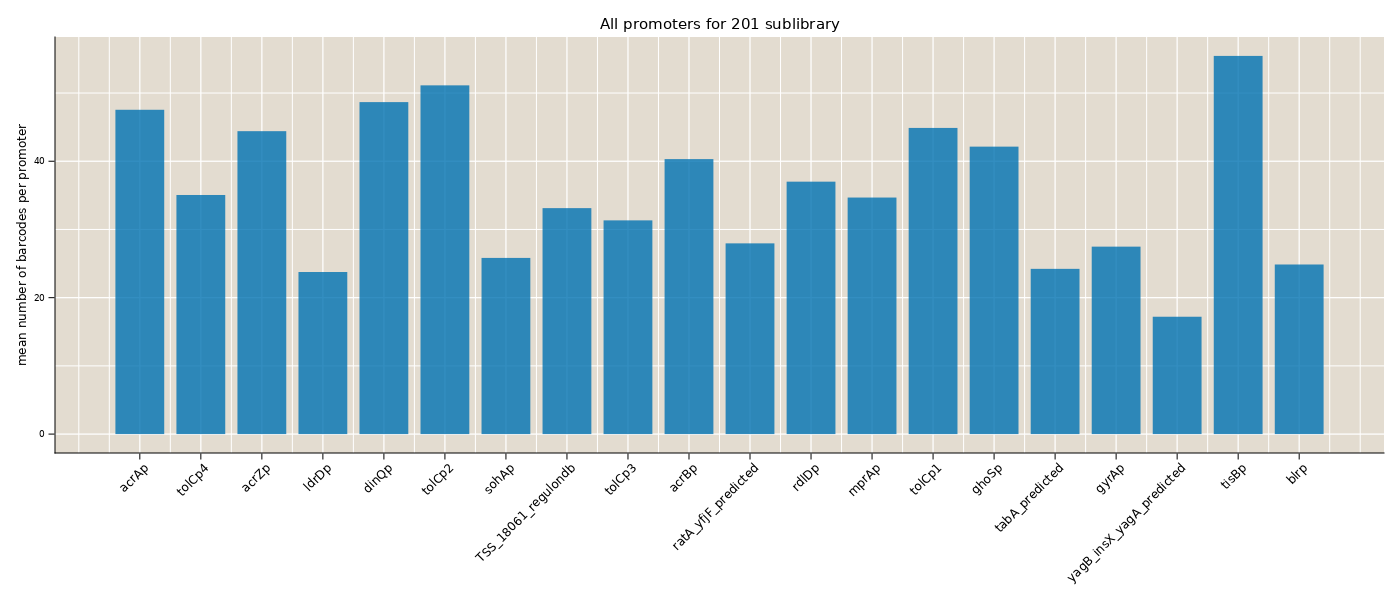

In [17]:
df_mean_barcodes_201 = combine(
    groupby(
        combine(
            groupby(
                df_filt_201, 
                [:promoter, :name, :rev_primer3]
                ), 
            nrow
            ), 
        [:name, :rev_primer3]
        ), 
    :nrow => mean => :mean_barcodes
)

df_mean_barcodes_201 = df_mean_barcodes_201[map(x -> x[1] == 201, df_mean_barcodes_201.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
ax.xticklabelsize = 12
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_201), 
    df_mean_barcodes_201.mean_barcodes,
)

ax.xticks = (1:nrow(df_mean_barcodes_201), df_mean_barcodes_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "mean number of barcodes per promoter"
ax.title = "All promoters for 201 sublibrary"
ax.titlesize = 15

fig

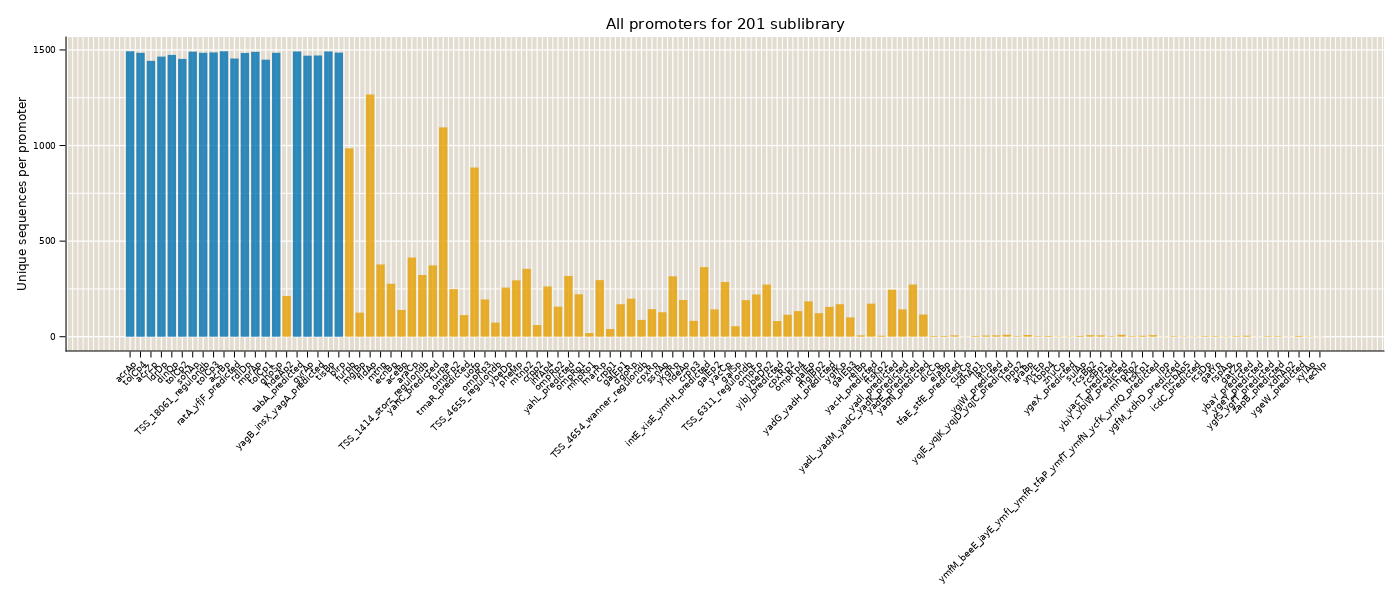

In [48]:
df_unique_per_prom_201 = combine(groupby(df_filt_201, [:name, :rev_primer3]), :promoter => num_unique);
df_unique_per_prom_201 = df_unique_per_prom_201[df_unique_per_prom_201.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_201), 
    df_unique_per_prom_201.promoter_num_unique .* map(x -> x[1] == 201, df_unique_per_prom_201.rev_primer3),
)

barplot!(
    ax, 
    1:nrow(df_unique_per_prom_201), 
    df_unique_per_prom_201.promoter_num_unique .* map(x -> x[1] != 201, df_unique_per_prom_201.rev_primer3),
)

ax.xticks = (1:nrow(df_unique_per_prom_201), df_unique_per_prom_201.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "Unique sequences per promoter"
ax.title = "All promoters for 201 sublibrary"
ax.titlesize=15
save("../../../figures/seq_per_prom_201.pdf", fig)
fig

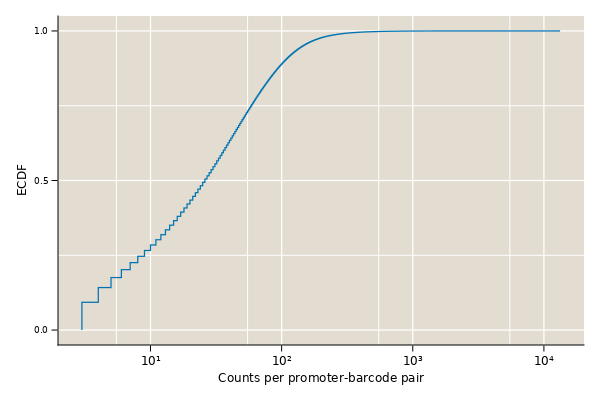

In [19]:
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
ax.ylabel = "ECDF"
ax.xlabel = "Counts per promoter-barcode pair"
ax.xticklabelsize=12
lines!(ax, sort(df_filt_201.counts),1/nrow(df_filt_201):1/nrow(df_filt_201):1)
fig

In [20]:
df_per_p3 = combine(groupby(df_filt_201, :rev_primer3), :counts => sum => :counts)

,rev_primer3,counts
,Tuple…,Int64
1,"(201, (212, 230))",53015619
2,"(0, (0, 0))",6781524
3,"(203, (212, 230))",58083
4,"(205, (212, 230))",439191
5,"(204, (212, 230))",90955
6,"(202, (212, 230))",61859
7,"(208, (212, 230))",135729
8,"(207, (212, 230))",38090
9,"(206, (212, 230))",26041


## Import Data 204

In [21]:
# Import data file
df_204 = CSV.read(
    "../../../data/barcodes/20220514_mapping/204_collapsed.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_204.barcode = map(x -> LongDNA{4}(x), df_204.barcode)
df_204.promoter = map(x -> LongDNA{4}(x), df_204.promoter)

# Display first lines
first(df_204, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,13465,ACTCCCAGTGTGTTACCTAA,GGCTGCTGATCCAACGCGGACGTGATTTGCGTGGCTAAGGCTATTTCCTCTCGTCTGGATTTGGGGGAGAGGAGTTGTGACGGCTATCACCCTTTACCAACAATGGTCAGGGTTGAGTGGTTTTCGGCGAAGAAGGAGGGCGTTGTTAGGTTGGGTACTT
2,12844,CACATTTATTATGTGGTGGC,GGGTTTGCACGAGGTGTTAATCTCTTTACAACAAAGCAACATAAAAAAGTGGCTGCATAGTTAAGGATGGTCTTTAGAGTGTTTCCCTCTGTAAAAACTTCGTTAATTCGCATGTTGATAATGACCTTTATCAACGAATCCCAAGATTCGTCAAAATTTT
3,11652,GGGTATGTGGGAATTCTGTC,AGGCGACATATAGCAATGACGTTGGTGCAATAAAAGATAGTTTAGCTAATATATCTATTCAAATTTGTGATAAACGTCAAAAAATTTGTTGACCGAACTGGTTATTTATAAAAGGGCACTTACGAAGTGGAGTCTTTTTTAAAGCTATGAAATACCAATG
4,11426,TGGCTGGGGGCTTTGCGGTA,GGTCCCTGATCCAACGTGGGCGAGGTTGGCCTAGCTAAGGCTAATTCGTCTCCCATGGATTTGGGGGAGATGAGTTTTGACGGCTATCACACTTTATCAACAATCGTCAGGGTAGGCTGCTTTTCGGCTAAGGAGGAAGGCGATGTTAGGTTGGTTGATT
5,11266,TCATGCCATTGCGTTGCAGT,GGATTTTGACAGGGTGTTAATTTGTTTACAAAAAAGCAACATAAAGAATGGGCTGAATCGTCATAGAGGGACTAGAGATTGTTTCCCTCCGCAAACACTTCGTTAATTCGCATGTTGATAATCATCTTTCTCAACGAATCCCATGATTAGTCAAAATTTA


## Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [22]:
df_filt_204 = df_204[df_204.counts .> 2, :]
last(df_filt_204, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTTATAACACAAAATATTCTAGAAAAACGGGGGGGGGGGGGGG
2,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTTATAACACAAAATATTCTAGAAAAACCGGGGGGGGGGGGGG
3,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTTATAACACAAAATATTCTACAAAAACCGGGGGGGGGGGGGG
4,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTAATAACACAAAATATTCTAGAAAAACGGGGGGGGGGGGGGG
5,3,AAAAAAAAAAAACGACAAAA,CGCCGCCATACAAACCAATCCAAACAAAGAAAAAAAACCAAAAAACCCAAAAAACGACATCACGAAAAATCATTTTGAAAAGCATACGATCATATTTAGCTAAATATATAGAGAAATCTAATAACACAAAATATTCTAGAAAAACCGGGGGGGGGGGGGG


## Identify promoters

Now we import the twist order to identify the sequences for each type.

In [23]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_204)
    try
        push!(name_list, dict_twist_sequences[df_filt_204.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_204.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_204.promoter[i]])
    catch e
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_204, 1, :name => name_list);
insertcols!(df_filt_204, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_204, 3, :rev_primer3 => primer3_list);

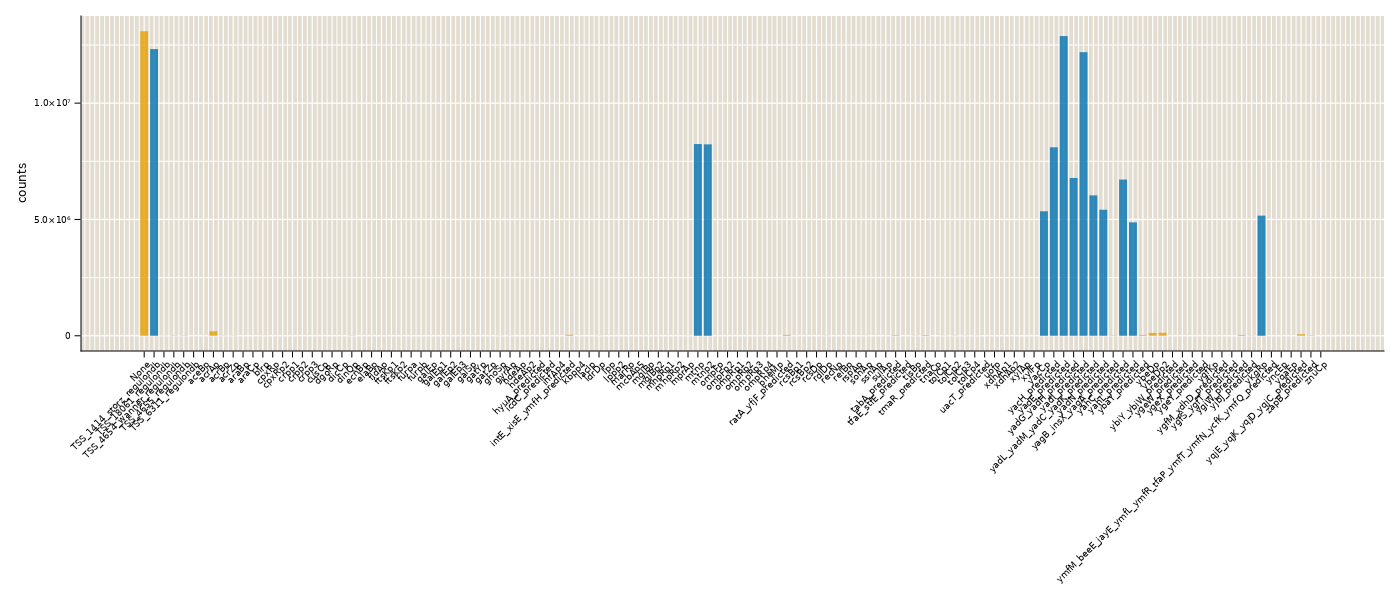

In [53]:
df_per_promoter_204 = combine(groupby(df_filt_204, [:name, :rev_primer3]), :counts => sum => :counts)
sort!(df_per_promoter_204, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_204), 
    df_per_promoter_204.counts .* map(x -> x[1] == 204, df_per_promoter_204.rev_primer3),
)
barplot!(
    ax, 
    1:nrow(df_per_promoter_204), 
    df_per_promoter_204.counts .* map(x -> x[1] != 204, df_per_promoter_204.rev_primer3),
)
ax.xticks = (1:nrow(df_per_promoter_204), df_per_promoter_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

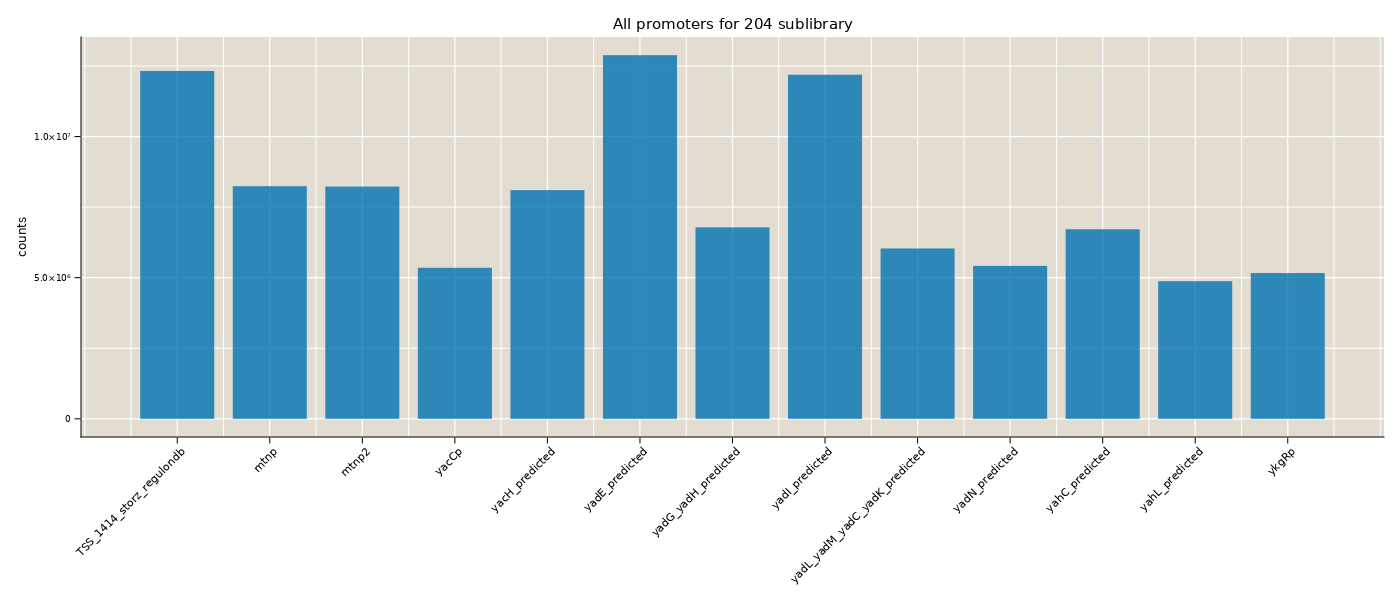

In [25]:
df_per_promoter_204_only = df_per_promoter_204[map(x -> x[1] == 204, df_per_promoter_204.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
ax.xticklabelsize=11

barplot!(
    ax, 
    1:nrow(df_per_promoter_204_only), 
    df_per_promoter_204_only.counts,
)

ax.xticks = (1:nrow(df_per_promoter_204_only), df_per_promoter_204_only.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"
ax.title = "All promoters for 204 sublibrary"
ax.titlesize=15

fig

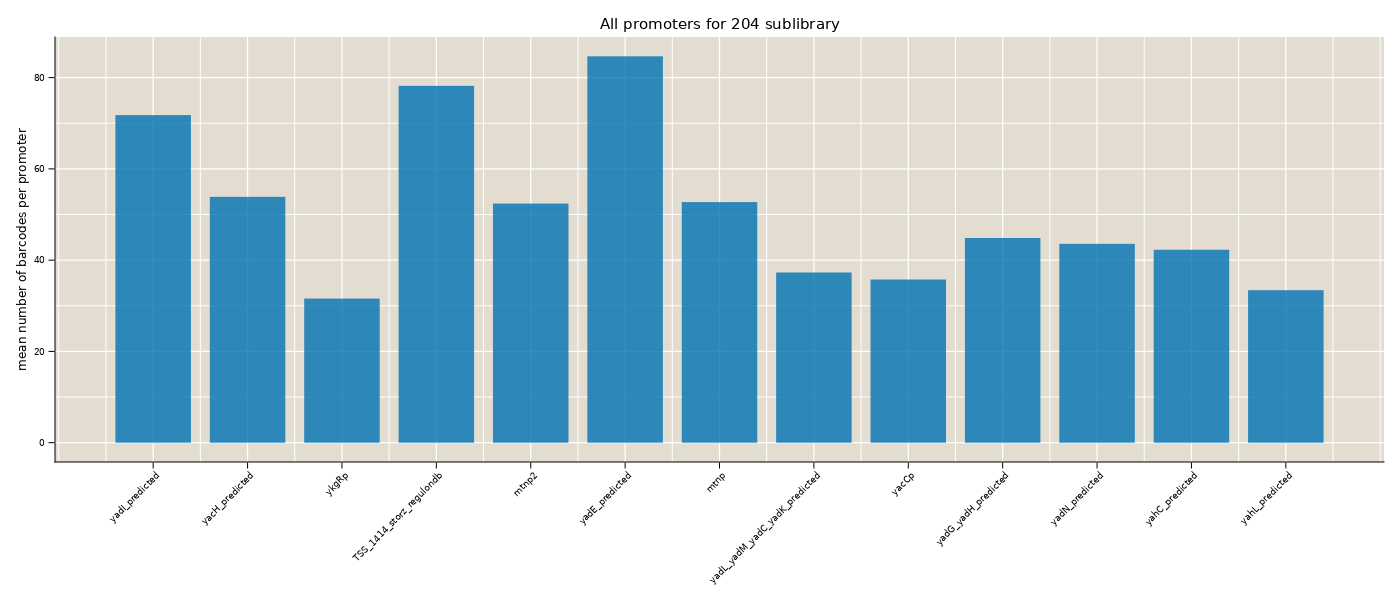

In [26]:
df_mean_barcodes_204 = combine(
    groupby(
        combine(
            groupby(
                df_filt_204, 
                [:promoter, :name, :rev_primer3]
                ), 
            nrow
            ), 
        [:name, :rev_primer3]
        ), 
    :nrow => mean => :mean_barcodes
)

df_mean_barcodes_204 = df_mean_barcodes_204[map(x -> x[1] == 204, df_mean_barcodes_204.rev_primer3), :]
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_204), 
    df_mean_barcodes_204.mean_barcodes,
)

ax.xticks = (1:nrow(df_mean_barcodes_204), df_mean_barcodes_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "mean number of barcodes per promoter"
ax.title = "All promoters for 204 sublibrary"
ax.titlesize=15

fig

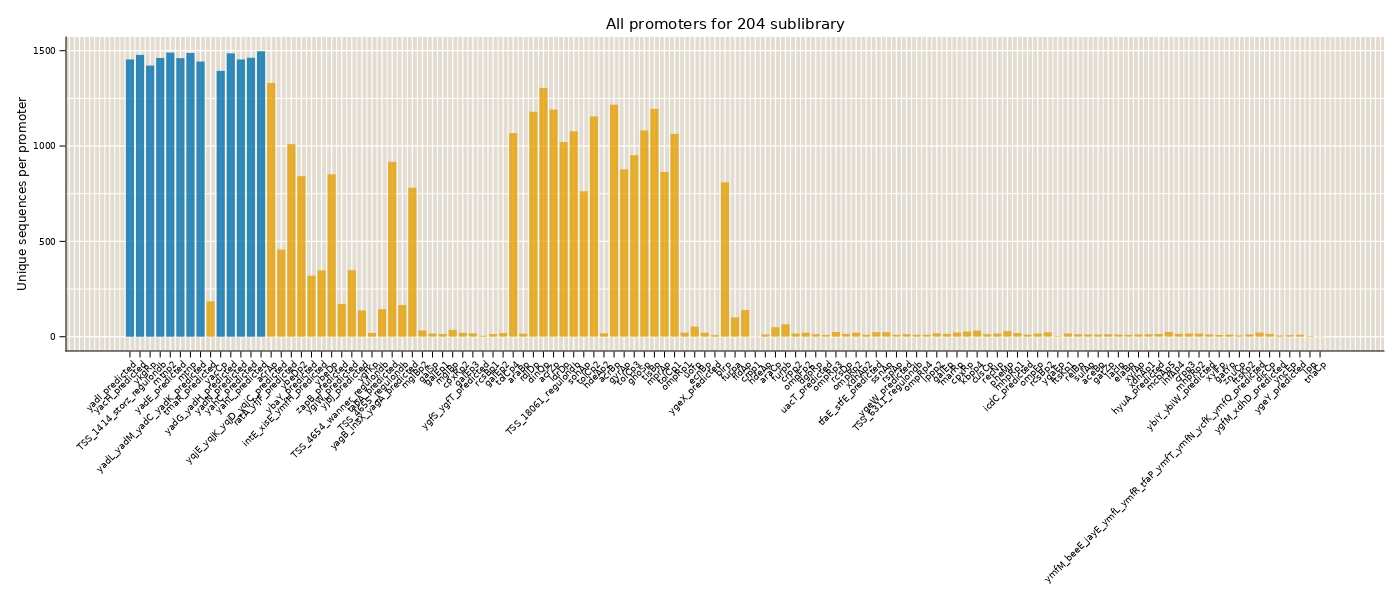

In [50]:
df_unique_per_prom_204 = combine(groupby(df_filt_204, [:name, :rev_primer3]), :promoter => num_unique);
df_unique_per_prom_204 = df_unique_per_prom_204[df_unique_per_prom_204.name .!= "None", :]

fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom_204), 
    df_unique_per_prom_204.promoter_num_unique .* map(x -> x[1] == 204, df_unique_per_prom_204.rev_primer3),
)

barplot!(
    ax, 
    1:nrow(df_unique_per_prom_204), 
    df_unique_per_prom_204.promoter_num_unique .* map(x -> x[1] != 204, df_unique_per_prom_204.rev_primer3),
)

ax.xticks = (1:nrow(df_unique_per_prom_204), df_unique_per_prom_204.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "Unique sequences per promoter"
ax.title = "All promoters for 204 sublibrary"
ax.titlesize=15
save("../../../figures/seq_per_prom_204.pdf", fig)
fig

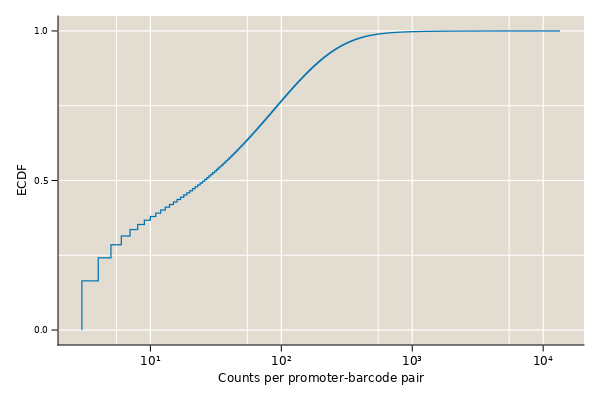

In [28]:
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
ax.ylabel = "ECDF"
ax.xlabel = "Counts per promoter-barcode pair"
ax.xticklabelsize=12
lines!(ax, sort(df_filt_204.counts),1/nrow(df_filt_204):1/nrow(df_filt_204):1)
fig

In [29]:
df_per_p3 = combine(groupby(df_filt_204, :rev_primer3), :counts => sum => :counts)

,rev_primer3,counts
,Tuple…,Int64
1,"(204, (212, 230))",102315345
2,"(0, (0, 0))",13091222
3,"(207, (212, 230))",450204
4,"(201, (212, 230))",408262
5,"(205, (212, 230))",75402
6,"(206, (212, 230))",3081
7,"(203, (212, 230))",2412
8,"(208, (212, 230))",2698
9,"(202, (212, 230))",994


In [30]:
# Import data file
df_100 = CSV.read(
    "../../../data/barcodes/20220514_mapping/100_collapsed_.txt", 
    DataFrame, 
    delim=" ", 
    ignorerepeated=true, 
    header=[:counts, :barcode, :promoter]
)

# Fix types
df_100.barcode = map(x -> LongDNA{4}(x), df_100.barcode)
df_100.promoter = map(x -> LongDNA{4}(x), df_100.promoter)

# Display first lines
first(df_100, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,8971,TGTCCAGCCTAACTCAGCGT,AGGAGATATCATCGGCGTATCCTGTAAAGAAGGTGAAGTGACAGAAGGCATATTTGAAAAATACCGTATCGCTACATACATAGGAGCCAGCTGGAAGCCTTACATCATCGCCGCGATGATCCTTTCCCGTAAATATGCTAAACCAGTTGCACCTCTCGAG
2,8661,ATGGTCAGTAAAGAGTCTTG,AGCGGAGTTCCGTAGCCGGGGCAGCGTTTAAATTTCCACTTGCATGTAGCACAGAGTGCAGTCATGCTCGTTTGCTGATTCCGCAAGCCTGGCTGTTCTGCTATGATTGCCTTAATACCTGGGCGATTTTCCACCCCCATTTCAATAAGTTTCAAGAGGT
3,8483,AATCGTCTCTGGGAGTTGTA,CCGGAAGGTAACTTCTTCGGCAAATTCATTGATTACATTAAATTAATGTTCCATGACTGGTTGAGTTAAAAACTAAACACTTGAAAGTGTAATTTCCGTCCCGATAGTCGATGCATCAGGAAAAAAGTCACGCCTTCTGGCGGGAGTTGTTATTGGATTA
4,7874,CCCCGAGGCCGACCTATGAA,CCAGAAGGTAACTTCTTCGGCATAATCATTGATTACATAAAATTAATATTCTTTCACTGGTTTGGTAAAAAATTAAACACTTGAAAGTGGAGTGTCCGGCCCCATATACTAGGCATCAGTAAAAAACTCCCGCCTTCTGGGGGGAGTGGCTGTTTAATTG
5,7097,GCCACGAACAGATTGTAAAG,GCCTGCATAACAATGTCCTGGCAAATGTCTTATTGTGAAGGAAACCGAACGCCACGCAAACCGGACCGGACAACAGTGGAGAACTTTACTGTCCTTAGCGGTTAGGATAGCCTCTTGACTATATCTGGAGTTGACCATGTTAGAGTTATTAATAAGTCTG


## Filtering

Now we filter all barcode promoter combinations that occur more than 2.

In [31]:
df_filt_100 = df_100[df_100.counts .> 2, :]
last(df_filt_100, 5)

,counts,barcode,promoter
,Int64,LongSequ…,LongSequ…
1,3,AAAAAAAAATAGATTAGTAG,GTGCGTTGGCCTATGGACTAGCCCGGAAGGGGATGACGATTATATAACCCACAAGAATCATTTTTCTACAACAATACATTTACTTTATTTGTCACTGTCGGTACTACATCGGGTGAAATTAATGAGGTAATTACCAAGTGGATAGTTCGTTTGGCCCGCA
2,3,AAAAAAAAACTGTAAGTAAT,CAGGTTGTCGGGCTTAAGCATTGTTAATGTCCTAGTACTAATAGTGAATTAAATGCGAATTTCAACAACGTTTGACTGCCGTTTGAGCAGTCACGTATTAAATTCAGGCACCTGAACGCCCTATGCCACGTAACGCCAAGATTCTGCGGTTGCGGCTTCT
3,3,AAAAAAAAAATAGATTAGTC,GTGCGTTGGCCTATGGACTAGCCCGGAAGGGGATGACGATTATATAACCCACAAGAATCATTTTTCTACAACAATACATTTACTTTATTTGTCACTGTCGGTACTACATCGGGTGAAATTAATGAGGTAATTACCAAGTGGATAGTTCGTTTGGCCCGCA
4,3,AAAAAAAAAAGGCTGGGGAA,GTTTCGGGTCTTTCCCTGAGACGGAGGTCTATGAAGAAGAGGGTATCCCACACATTGGCAGGGCACGCGAGGTAATTCAGGCGTAGTCAACAAACCTTGTCTATAGTGAGTGACAAGCTTTACGCAAATGGGGCACGACAATGTCTAATCAGTTTGGGGA
5,3,AAAAAAAAAAAAAAAAAAAA,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


## Identify promoters

Now we import the twist order to identify the sequences for each type.

In [32]:
name_list = String[]
primer2_list = Tuple{Int64, Tuple{Int64, Int64}}[]
primer3_list = Tuple{Int64, Tuple{Int64, Int64}}[]

for i in 1:nrow(df_filt_100)
    try
        push!(name_list, dict_twist_sequences[df_filt_100.promoter[i]])
        push!(primer2_list, dict_twist_primer2[df_filt_100.promoter[i]])
        push!(primer3_list, dict_twist_primer3[df_filt_100.promoter[i]])
    catch e
        push!(name_list, "None")
        push!(primer2_list, (0, (0, 0)))
        push!(primer3_list, (0, (0, 0)))
    end
end

insertcols!(df_filt_100, 1, :name => name_list);
insertcols!(df_filt_100, 2, :rev_primer2 => primer2_list);
insertcols!(df_filt_100, 3, :rev_primer3 => primer3_list);

In [33]:
length.(df_filt_100.promoter) |> unique

1-element Vector{Int64}:
 160

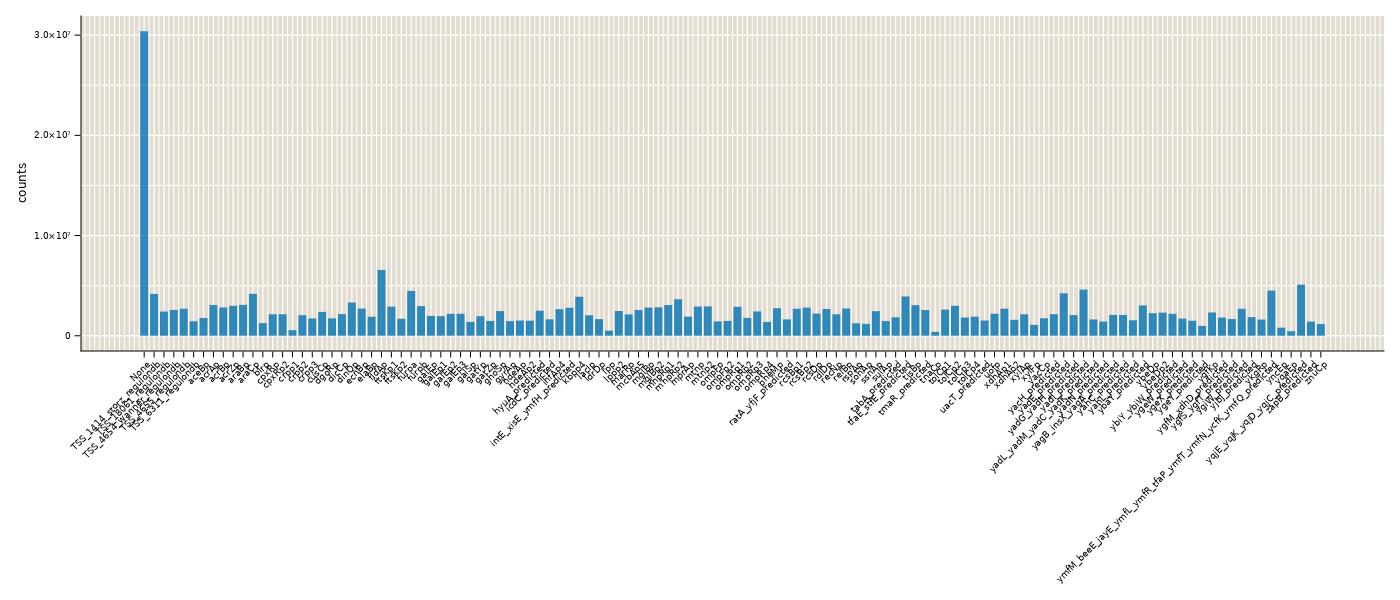

In [34]:
df_per_promoter_100 = combine(groupby(df_filt_100, [:name, :rev_primer3, :rev_primer2]), :counts => sum => :counts)
sort!(df_per_promoter_100, :name)
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_per_promoter_100), 
    df_per_promoter_100.counts,
)

ax.xticks = (1:nrow(df_per_promoter_100), df_per_promoter_100.name)
ax.xticklabelrotation = pi/4
ax.ylabel = "counts"

fig

In [35]:
df_mean_barcodes_100 = combine(
    groupby(
        combine(
            groupby(
                df_filt_100, 
                [:promoter, :name, :rev_primer2, :rev_primer3]
                ), 
            nrow
            ), 
        [:name, :rev_primer2, :rev_primer3]
        ), 
    :nrow => mean => :mean_barcodes
)

,name,rev_primer2,rev_primer3,mean_barcodes
,String,Tuple…,Tuple…,Float64
1,ygeX_predicted,"(119, (193, 211))","(206, (212, 230))",19.3264
2,fldAp,"(111, (193, 211))","(205, (212, 230))",86.3128
3,ybeDp2,"(109, (193, 211))","(207, (212, 230))",32.0757
4,ybeDp,"(109, (193, 211))","(207, (212, 230))",31.2682
5,acrZp,"(110, (193, 211))","(201, (212, 230))",42.0361
6,acrBp,"(110, (193, 211))","(201, (212, 230))",36.8953
7,marRp,"(103, (193, 211))","(202, (212, 230))",30.7073
8,rspAp,"(101, (193, 211))","(202, (212, 230))",17.7244
9,kbpp4,"(108, (193, 211))","(207, (212, 230))",49.6568


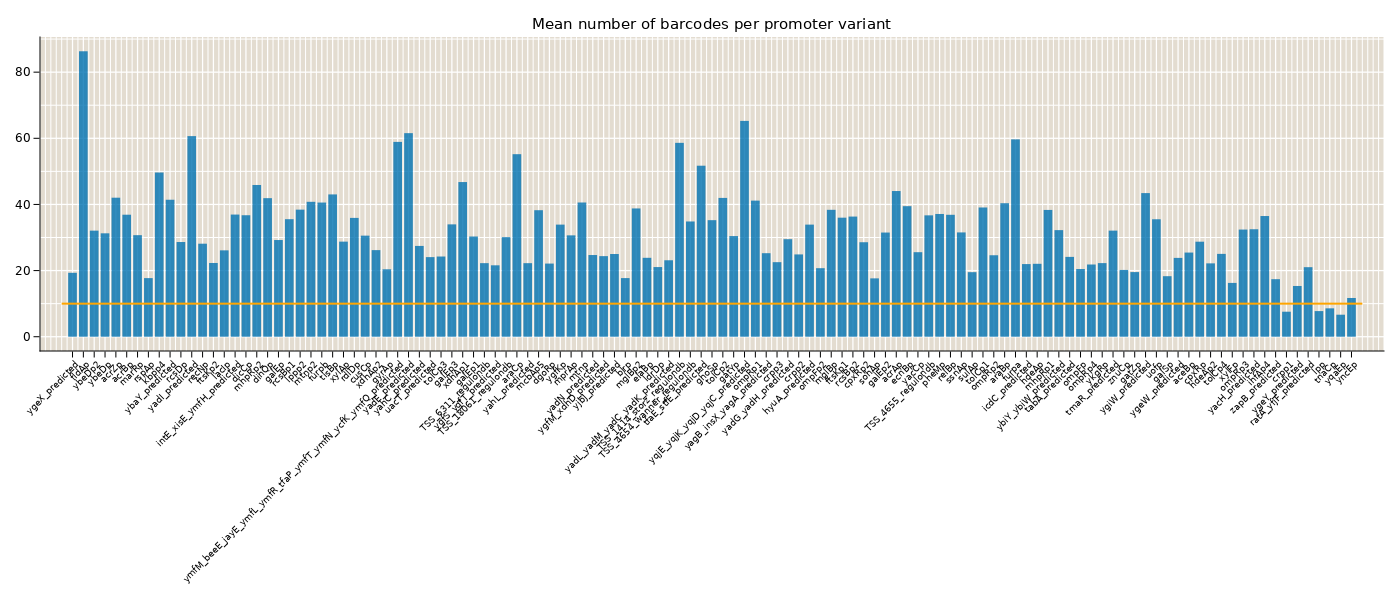

In [92]:
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
df_mean_barcodes_100 = df_mean_barcodes_100[df_mean_barcodes_100.name .!= "None", :]
barplot!(
    ax, 
    1:nrow(df_mean_barcodes_100), 
    df_mean_barcodes_100.mean_barcodes,
)
ax.yticklabelsize = 12
ax.titlesize=15

xlims!(-2, nrow(df_unique_per_prom)+3)
ax.xticks = (1:nrow(df_mean_barcodes_100), df_mean_barcodes_100.name)

mini = lines!(ax, [0, nrow(df_mean_barcodes_100)+1], [10, 10], color="orange", linewidth=2)
ax.xticklabelrotation = pi/4
ax.title = "Mean number of barcodes per promoter variant"

save("../../../figures/bc_per_prom_100.pdf", fig)
fig

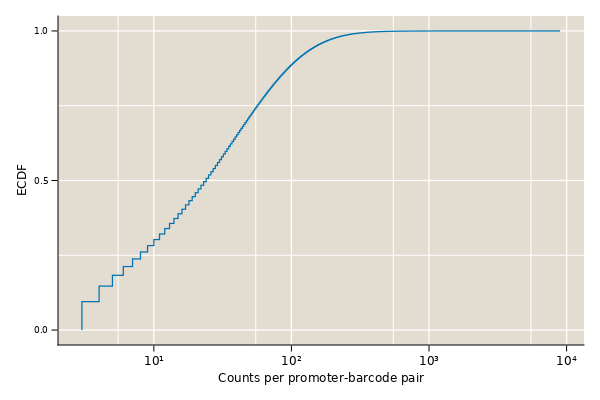

In [37]:
fig = Figure(resolution=(600, 400))
ax = Axis(fig[1, 1], xscale=log10)
ax.ylabel = "ECDF"
ax.xlabel = "Counts per promoter-barcode pair"
ax.xticklabelsize=12
lines!(ax, sort(df_filt_100.counts),1/nrow(df_filt_100):1/nrow(df_filt_100):1)
fig

In [38]:
num_unique(x) = length(unique(x))
df_unique_per_prom = combine(groupby(df_filt_100, :name), :promoter => num_unique);

In [ ]:
df_unique_per_prom = combine(groupby(df_filt_100, :name), :promoter => num_unique);
df_unique_per_prom = df_unique_per_prom[df_unique_per_prom.name .!= "None", :]

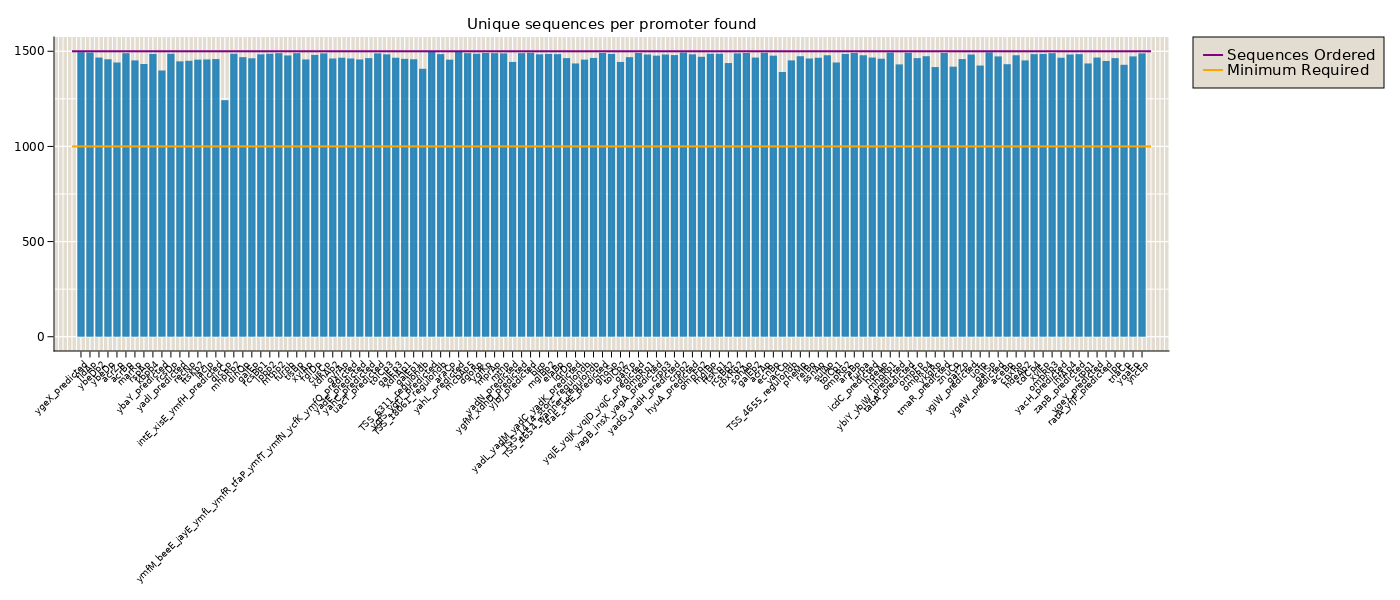

In [88]:
fig = Figure(resolution=(1400, 600))
ax = Axis(fig[1,1])
barplot!(
    ax, 
    1:nrow(df_unique_per_prom), 
    df_unique_per_prom.promoter_num_unique,
)

ax.xticks = (1:nrow(df_unique_per_prom), df_unique_per_prom.name)
ax.xticklabelrotation = pi/4
ax.yticklabelsize = 12
#ax.ylabel = "Unique sequences per promoter"
ax.title = "Unique sequences per promoter found"
ax.titlesize=15
xlims!(-2, nrow(df_unique_per_prom)+3)

maxi = lines!(ax, [0, nrow(df_unique_per_prom)+1], [1500, 1500], color="purple", linewidth=2)
mini = lines!(ax, [0, nrow(df_unique_per_prom)+1], [1000, 1000], color="orange", linewidth=2)
Legend(
    fig[1, 2], 
    [maxi, mini], 
    ["Sequences Ordered", "Minimum Required"], 
    valign = :top, 
    labelsize=15
)

save("../../../figures/seq_per_prom_100.pdf", fig)
fig

In [40]:
nrow(df_unique_per_prom)

119